# Self-Driving Car Engineer Nanodegree
*Project of this notebook is the first project in the first term that started at Feb 2017.*
## Project: Traffic Sign Recognition Classifier
***
In this notebook, I implement a traffic sign recognition classifier for the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).
![LeNet Architecture](2-stage_ConvNet_architecture.png)
Source: [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf)

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 0: Load Data

Load the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset), which comes pre-loaded with TensorFlow.

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file =   "./examples/train.p"
validation_file = "./examples/valid.p"
testing_file =    "./examples/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

print()
print('Load complete.')


Load complete.


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES** 

In [2]:
import numpy as np

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

n_train = len(X_train)
n_valid = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
classes = list(np.unique(y_train))
n_classes = len(classes)

print()
print("Training Set:   {} samples".format(n_train))
print("Validation Set: {} samples".format(n_valid))
print("Test Set:       {} samples".format(n_train))
print()
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       34799 samples

Image data shape = (32, 32, 3)
Number of classes = 43


### Histogram with the number of each class in the train, test, and validation set

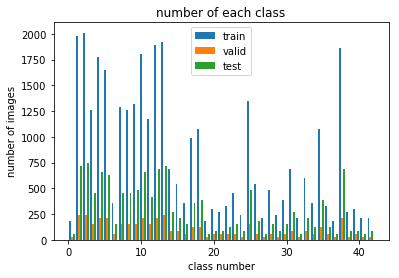

In [37]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

ax = plt.subplot()
y_multi = [y_train, y_valid, y_test]
ax.hist(y_multi, bins=n_classes, histtype='bar',
        label=['train', 'valid', 'test'])
ax.legend(prop={'size': 10})
ax.set_title('number of each class')
ax.set_xlabel('class number')
ax.set_ylabel('number of images')

### Representative images of each class

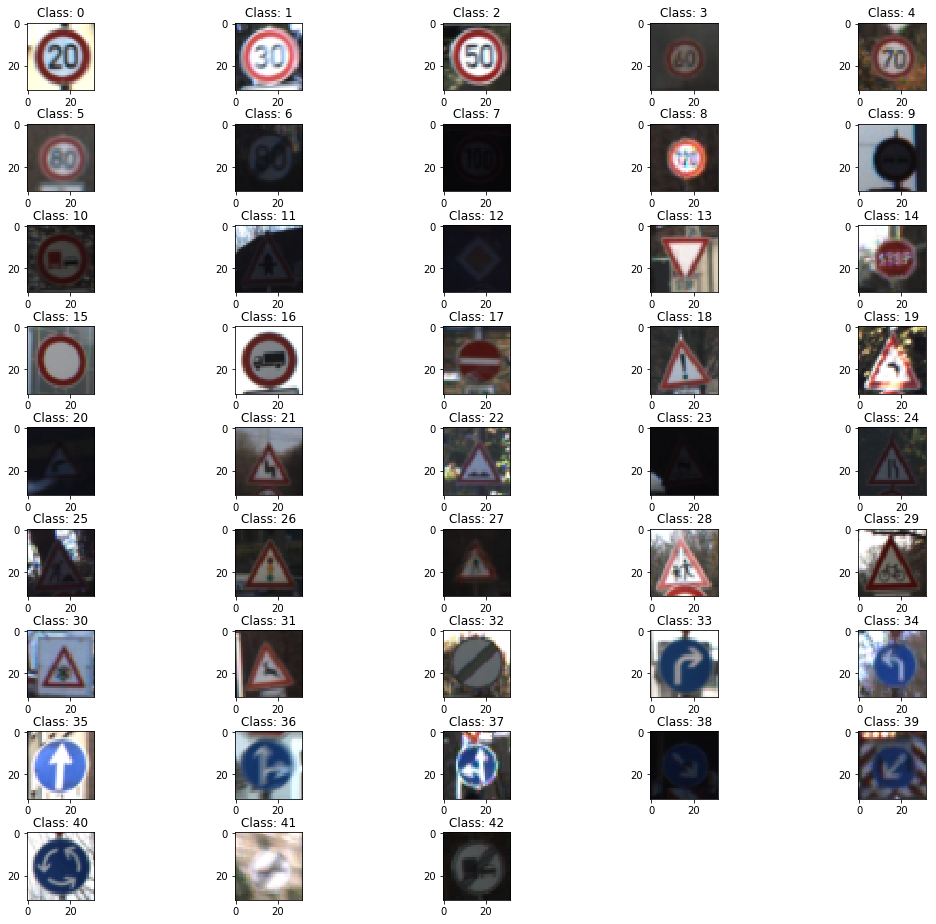

In [38]:
import matplotlib.gridspec as gridspec

# get value of each class
row_cnt, col_cnt = 10, 5
fig = plt.figure(figsize=(18,18))
gs = gridspec.GridSpec(row_cnt, col_cnt, hspace=0.5)
gs_idx = 0
for c in classes:
    arr = np.argwhere(y_train == c)
    idx = arr[np.random.randint(0, high=len(arr))][0]

    ax = fig.add_subplot(gs[gs_idx])
    ax.imshow(X_train[idx])
    ax.set_title('Class: ' + str(c))
    gs_idx += 1
    if gs_idx >= row_cnt * col_cnt: break

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs.

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process Data

- encode One-Hot labels
- histogram equalization

Original image shape:    (32, 32, 3)
Preprocessed image shape:  (32, 32, 3)


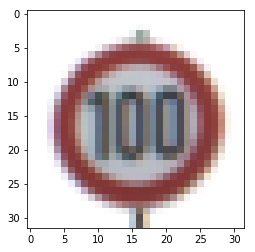

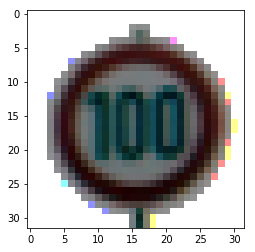

In [39]:
import cv2
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

# change classes to one-hot labels
def convert_to_onehot(y_data, n_classes):
    enc = OneHotEncoder()
    y_enc = enc.fit(np.arange(n_classes).reshape(-1, 1))
    labels = y_enc.transform(y_data.reshape(-1, 1)).toarray()
    return labels

# histogram equalization
# http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
def convert_to_eqhist(image_data):
    eqhist = []
    for image in image_data:
        img = image.copy()
        img[:, :, 0] = cv2.equalizeHist(image[:, :, 0])
        img[:, :, 1] = cv2.equalizeHist(image[:, :, 1])
        img[:, :, 2] = cv2.equalizeHist(image[:, :, 2])
        eqhist.append(img)

    return eqhist

# One-Hot encoding
labels_train = convert_to_onehot(y_train, n_classes)
labels_test = convert_to_onehot(y_test, n_classes)

# histogram equalization
X_train_e = convert_to_eqhist(X_train)

print('Original image shape:   ', X_train[100].shape)
print('Preprocessed image shape: ', X_train_e[100].shape)

i = np.random.randint(0, high=n_train)
plt.imshow(X_train[i])
plt.figure()
plt.imshow(X_train_e[i])

### Model Architecture

Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) architecture.

This is the only cell you need to edit.
#### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since preprocessed images are grayscale and normalized, C is 1 in this case.

#### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

#### Output
Return the result of the 2nd fully connected layer.

In [45]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), 
                                              mean = mu, 
                                              stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], 
                           padding='VALID') + conv1_b
    print(conv1)

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], 
                           strides=[1, 2, 2, 1], padding='VALID')
    print(conv1)

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), 
                                              mean = mu, 
                                              stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], 
                           padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], 
                           strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), 
                                            mean = mu, 
                                            stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), 
                                             mean = mu, 
                                             stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), 
                                             mean = mu, 
                                             stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

# Learning parameters
learning_rate = 0.00001
n_epochs = 10
batch_size = 128

# Features and labels
x = tf.placeholder(tf.float32, 
                   (None, image_shape[0], image_shape[1], 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
#keep_prob = tf.placeholder(tf.float32)

# Training Pipeline
logits = LeNet(x)

# Loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_operation = optimizer.minimize(loss_operation)

# Accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, 
                                            tf.float32))

print('Model Complete')

Tensor("add_75:0", shape=(?, 28, 28, 6), dtype=float32)
Tensor("MaxPool_30:0", shape=(?, 14, 14, 6), dtype=float32)
Model Complete


### Train, Validate and Test the Model

In [46]:
def evaluate(X_data, y_data, batch_size, accuracy_operation):
    num_examples = len(X_data)
    total_accuracy = 0
    
    for offset in range(0, num_examples, batch_size):
        batch_x = X_data[offset: offset + batch_size]
        batch_y = y_data[offset: offset + batch_size]

        accuracy = sess.run(accuracy_operation, 
                            feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

feature_data = X_train
label_data = y_train
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(feature_data)
    
    print("Training...")
    print()

    for epoch in range(n_epochs):
        feature_data, label_data = shuffle(feature_data, label_data)

        for offset in range(0, num_examples, batch_size):
            end_idx = offset + batch_size
            
            batch_x = feature_data[offset : end_idx]
            batch_y = label_data[offset : end_idx]

            sess.run(training_operation, 
                     feed_dict={x: batch_x, y: batch_y})

        print("EPOCH {} ...".format(epoch + 1))
        validation_accuracy = evaluate(X_valid, y_valid, 
                                       batch_size, 
                                       accuracy_operation)
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet.ckpt')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.050

EPOCH 2 ...
Validation Accuracy = 0.058

EPOCH 3 ...
Validation Accuracy = 0.071

EPOCH 4 ...
Validation Accuracy = 0.090

EPOCH 5 ...
Validation Accuracy = 0.109

EPOCH 6 ...
Validation Accuracy = 0.122

EPOCH 7 ...
Validation Accuracy = 0.130

EPOCH 8 ...
Validation Accuracy = 0.137

EPOCH 9 ...
Validation Accuracy = 0.153

EPOCH 10 ...
Validation Accuracy = 0.161



NameError: name 'saver' is not defined

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))